In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np

from scipy.integrate import odeint
import matplotlib.pyplot as plt
import pandas as pd

from solvers import *
from plot import *

In [2]:
def getMetaData(country = "India"):
    popDict = {"India": 1366417755, "Netherlands": 17097123, "Mexico": 127575528, "Mumbai": 20411000}
    underreporting_factor = {"India": 12.33505578, "Netherlands": 2.8345572, "Mexico": 43.12753953, "Mumbai": 18.86570445}
    bedsPerCapita= {"India": 0.53/1000, "Netherlands": 3.32/1000, "Mexico": 1.38/1000, "Mumbai": -1} 
    hospToReported= {"India": 0.5, "Netherlands": -1, "Mexico": -1, "Mumbai": -1} 
    
    return {"country": country, "population": popDict[country], "underreporting_factor": underreporting_factor[country],
           "bedsPerCapita": bedsPerCapita[country], "hospToReported": hospToReported[country]}   
        

In [3]:
meta = getMetaData("India")

df = pd.read_csv('./data/time_series_covid19_confirmed_global.csv')
df = df.drop(['Lat', 'Long'], axis =1)
df = df.groupby('Country/Region').agg('sum')
df = df.loc[meta['country']][98:-3]
print(df.tail())

dfrec = pd.read_csv('./data/time_series_covid19_recovered_global.csv')
dfrec = dfrec.drop(['Lat', 'Long'], axis =1)
dfrec = dfrec.groupby('Country/Region').agg('sum')
dfrec = dfrec.loc[meta['country']][98:-3]
print(dfrec.tail())

Rec_real = np.array(list(dfrec))
Conf_real = np.array(list(df))

deltaI_real = np.array([Conf_real[i] - Conf_real[i-1] for i in range(1, len(Conf_real))])
I_real = Conf_real - Rec_real

12/25/20    10169118
12/26/20    10187850
12/27/20    10207871
12/28/20    10224303
12/29/20    10244852
Name: India, dtype: int64
12/25/20    9740108
12/26/20    9761538
12/27/20    9782669
12/28/20    9807569
12/29/20    9834141
Name: India, dtype: int64


In [4]:
N = meta['population']
p = meta['bedsPerCapita']
underreporting_factor = meta['underreporting_factor']
reporting_percentage = 1/underreporting_factor
h = meta['hospToReported']

d = 5 #H bucket duratioon
gamma = 1/5.


Istar = N*p/(h*reporting_percentage*gamma*d)
print(Istar)

R0 = 0
r = 4.2
e = r/Istar

I0 = deltaI_real[0]*underreporting_factor/gamma
S0 = N - I0 - R0
beta0 = gamma*N/S0

Jstar = gamma*N
init = (S0, I0, R0)

delta_t = 0.001
tsteps = 400
t = np.linspace(0, tsteps-1, tsteps)
eta = 1


17866129.580309816


In [5]:
deltaI_real_c = deltaI_real*underreporting_factor
I_real_c = I_real*underreporting_factor

In [6]:
R_intervention_h = 0.8
R_intervention_l = 0.5
beta_intervention_h = R_intervention_h*gamma
beta_intervention_l = R_intervention_l*gamma
R_relaxation = 2.2
beta_relaxation = R_relaxation*gamma
beta_dI_h = []
beta_dI_l = []
T_intervention = 60
T_relaxation = 30
temp = 0
while temp < tsteps:
    if(temp+T_intervention>=tsteps):
        beta_dI_h.extend([beta_intervention_h for i in range(tsteps - temp)])
        beta_dI_l.extend([beta_intervention_l for i in range(tsteps - temp)])
        temp += tsteps - temp
    else:
        beta_dI_h.extend([beta_intervention_h for i in range(T_intervention)])
        beta_dI_l.extend([beta_intervention_l for i in range(T_intervention)])
        beta_dI_h.extend([beta_relaxation for i in range(min(T_relaxation, tsteps - temp))]) 
        beta_dI_l.extend([beta_relaxation for i in range(min(T_relaxation, tsteps - temp))])
        temp += T_intervention + min(T_relaxation, tsteps - temp)
beta_dI_h = np.array(beta_dI_h)
beta_dI_l = np.array(beta_dI_l)

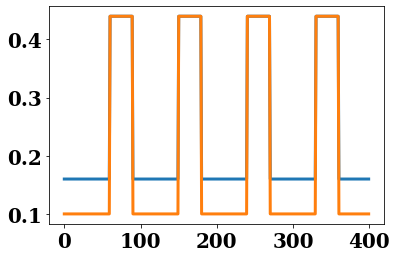

In [7]:
plt.plot(t, beta_dI_h)
plt.plot(t, beta_dI_l)

In [8]:
S_dI_h, I_dI_h, R_dI_h = solve_discrete_sir((S0, I0, R0), beta_dI_h, gamma, N, tsteps, delta_t=delta_t)
S_dI_l, I_dI_l, R_dI_l = solve_discrete_sir((S0, I0, R0), beta_dI_l, gamma, N, tsteps, delta_t=delta_t)

beta_cons = 2.2*gamma
S_cons, I_cons, R_cons = solve_discrete_sir((S0, I0, R0), beta_cons, gamma, N, tsteps, delta_t=delta_t)

In [9]:
def find_approximation(beta, klevels, loss_function):
    """
        Find the best approximation of beta (m,) sized array
        based on one of the klevels (k,) sized array. The
        goodness of approximation is based on 

        loss_function: (y, y_hat) -> R (positive reals)

        Returns: beta_approx (m,) sized array
        such that: 
            
            \sum_t loss_function(beta_approx(t), beta(t))
        i.e. pointwise loss values are minimized.

        Since, loss_function is positive and pointwise,
        elementwise minimum should minimise the global objective.

        TODO: Should we impose some sort of smoothness constraint
        on beta_approx(t) ?
    """
    num_steps = np.shape(beta)[0]
    num_levels = np.shape(klevels)[0]
    
    #TODO: Try out a vectorized implementation
    beta_approx = []
    for t in range(num_steps):
        beta_val = beta[t]
        losses = loss_function(beta_val, klevels)
        best_beta = klevels[np.argmin(losses)]
        beta_approx.append(best_beta)

    beta_approx = np.array(beta_approx)
    return beta_approx

In [10]:
S_ideal, I_ideal, R_ideal, beta_ideal = solve_sir_lv_control(S0, I0, R0, beta0, N, r, e, gamma, eta, t)

In [11]:
klevels = np.array([0.05*i for i in range(1,21)])
print(klevels)
loss_function = lambda x,y: (x-y)**2
beta_approx = find_approximation(beta_ideal, klevels, loss_function)

[0.05 0.1  0.15 0.2  0.25 0.3  0.35 0.4  0.45 0.5  0.55 0.6  0.65 0.7
 0.75 0.8  0.85 0.9  0.95 1.  ]


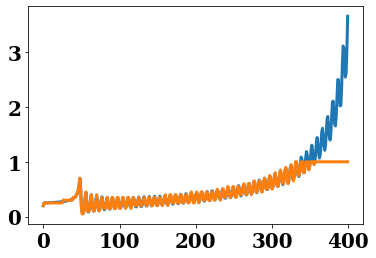

In [12]:
x = len(beta_ideal)
plt.plot(range(len(beta_ideal[:x])), beta_ideal[:x])
plt.plot(range(len(beta_ideal[:x])), beta_approx[:x])

In [13]:
S_approx, I_approx, R_approx = solve_discrete_sir((S0, I0, R0), beta_approx, gamma, N, tsteps, delta_t=delta_t)

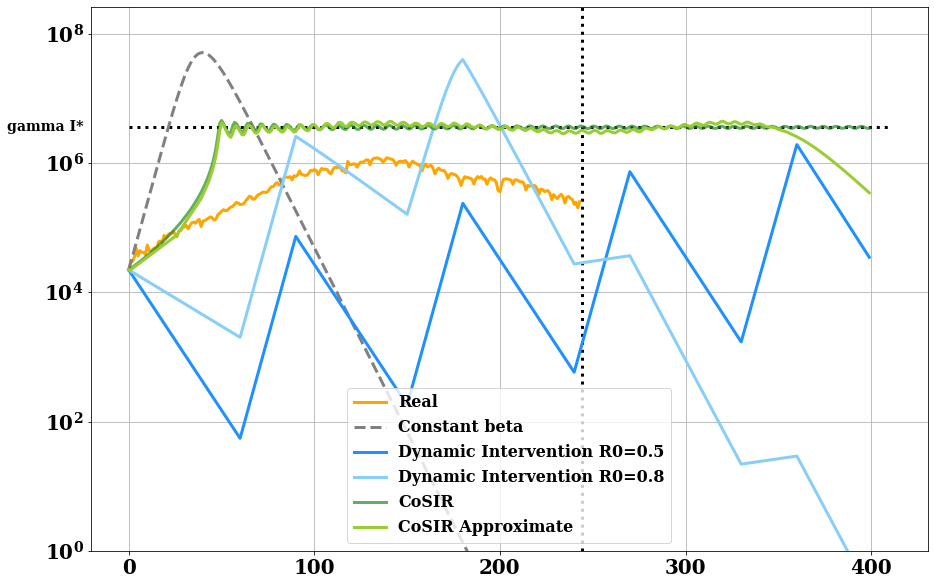

In [14]:
# plt.figure(figsize = (15, 10))
# plt.grid()
# plt.yscale("log")
# plt.ylim([1, 1e+9])
# plt.yticks([1, 10, 100, 1000, 1e+4, 1e+5, 1e+6, 1e+7, 1e+8])
# # plt.plot(t, S, label="CoSIR")
# # plt.plot(t, S_approx, label="CoSIR Approx")
# # plt.plot(t, S_dI, label = "Dynamic Intervention")
# plt.plot(t, I_ideal*gamma, label="CoSIR")
# plt.plot(t, I_approx*gamma, label="CoSIR Approx")
# plt.plot(t, I_cons*gamma, label= r'Constant \beta')
# plt.plot(t, I_dI_h*gamma, label = "Dynamic Intervention R = 0.8")
# plt.plot(t, I_dI_l*gamma, label = "Dynamic Intervention R = 0.5")
# plt.axhline(y=Istar*gamma, linestyle = '--', color = 'black')
# plt.axvline(x = len(deltaI_real), linestyle = '--')
# plt.plot(range(len(deltaI_real)), deltaI_real*50, label = "Real")
# plt.legend()
# # plt.plot(t, R)


import matplotlib.transforms as transforms
fig, ax = plt.subplots(figsize=(15,10))
plt.yscale('log')
plt.ylim(top=np.max(I_cons)*1.01, bottom=1)
plt.tick_params(axis='y', which='minor', left=False, right=False)


plt.hlines(y=Istar*gamma, xmin=0, xmax=tsteps+10, linestyles='dotted')
plt.axvline(x=len(deltaI_real), ls=':', color='black')

trans = transforms.blended_transform_factory(ax.get_yticklabels()[0].get_transform(), ax.transData)
ax.text(0, Istar*gamma, 'gamma I*', color="black", transform=trans, ha="right", va="center", fontsize=14)

trans = transforms.blended_transform_factory(ax.get_xticklabels()[0].get_transform(), ax.transData)

ax.plot(range(len(deltaI_real)), deltaI_real_c, '-', label='Real', color='orange')

ax.plot(t, I_cons*gamma, label='Constant beta', ls='--', color='grey')

ax.plot(t, I_dI_l*gamma, label='Dynamic Intervention R0=0.5', color='dodgerblue')
ax.plot(t, I_dI_h*gamma, label='Dynamic Intervention R0=0.8', color='lightskyblue')

ax.plot(t, I_ideal*gamma, '-', alpha=0.7, label='CoSIR', color='forestgreen')
ax.plot(t, I_approx*gamma, '-', label='CoSIR Approximate', color='yellowgreen')
plt.grid()
plt.legend()
plt.savefig('./graphs/{}_deltaIcasecounts.png'.format(meta['country']))

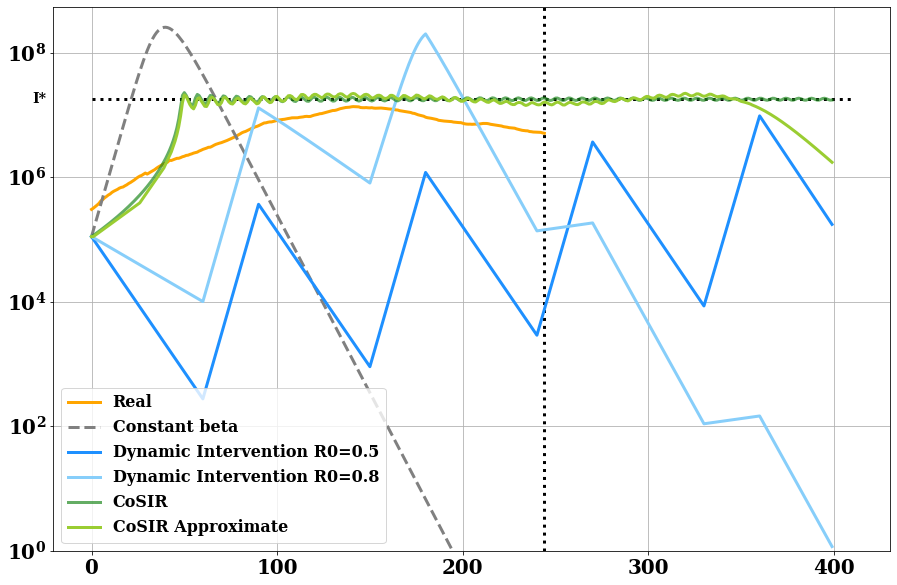

In [15]:
import matplotlib.transforms as transforms
fig, ax = plt.subplots(figsize=(15,10))
plt.yscale('log')
plt.ylim(top=np.max(I_cons)*2.1, bottom=1)
plt.tick_params(axis='y', which='minor', left=False, right=False)


plt.hlines(y=Istar, xmin=0, xmax = tsteps + 10, linestyles='dotted')
plt.axvline(x=len(deltaI_real), ls=':', color='black')

trans = transforms.blended_transform_factory(ax.get_yticklabels()[0].get_transform(), ax.transData)
ax.text(0, Istar, 'I*', color="black", transform=trans, ha="right", va="center",  fontsize=14)

trans = transforms.blended_transform_factory(ax.get_xticklabels()[0].get_transform(), ax.transData)
ax.plot(range(len(I_real_c)), I_real_c, '-', label='Real', color='orange')

ax.plot(t, I_cons, label='Constant beta', ls='--', color='grey')

ax.plot(t, I_dI_l, label='Dynamic Intervention R0=0.5', color='dodgerblue')
ax.plot(t, I_dI_h, label='Dynamic Intervention R0=0.8', color='lightskyblue')

ax.plot(t, I_ideal, '-', alpha=0.7, label='CoSIR', color='forestgreen')
ax.plot(t, I_approx, '-', label='CoSIR Approximate', color='yellowgreen')
plt.grid()
plt.legend()
plt.savefig('./graphs/{}_Icasecounts.png'.format(meta['country']))

In [16]:
def getControlMetrics(I, Istar):
    c = 0
    for idx, i in enumerate(I):
        c += np.abs(i-Istar)/Istar
    return c/len(I)

l = len(I_real)
# print("Till Current t")
print("Constant beta: {:.3f}".format(getControlMetrics(I_cons[:l]*gamma, Istar*gamma)))
print("Real: {:.3f}".format(getControlMetrics(deltaI_real*underreporting_factor, Istar*gamma)))
print("Dynamic Intervention R=0.8: {:.3f}".format(getControlMetrics(I_dI_h[:l]*gamma, Istar*gamma)))
print("Dynamic Intervention R=0.5: {:.3f}".format(getControlMetrics(I_dI_l[:l]*gamma, Istar*gamma)))
print("Ideal beta: {:.3f}".format(getControlMetrics(I_ideal[:l]*gamma, Istar*gamma)))
print("Approx beta: {:.3f}".format(getControlMetrics(I_approx[:l]*gamma, Istar*gamma)))


# print()
# print()
# print("Till Current t=500")
# print("Constant beta: {}".format(getControlMetrics(I_cons*gamma, Istar*gamma)))
# print("Ideal beta: {}".format(getControlMetrics(I_ideal*gamma, Istar*gamma)))
# print("Approx beta: {}".format(getControlMetrics(I_approx*gamma, Istar*gamma)))
# print("Dynamic Intervention beta R=0.8: {}".format(getControlMetrics(I_dI_h*gamma, Istar*gamma)))
# print("Dynamic Intervention beta R=0.5: {}".format(getControlMetrics(I_dI_l*gamma, Istar*gamma)))

Constant beta: 1.846
Real: 0.856
Dynamic Intervention R=0.8: 1.270
Dynamic Intervention R=0.5: 0.995
Ideal beta: 0.227
Approx beta: 0.269


In [17]:
def getIBelowAboveIstar(I, Istar):
    below = 0
    above = 0
    for i in I:
        if(i<=Istar):
            below+=Istar-i
        else:
            above+=i-Istar
    return below/(len(I)*Istar), above/(len(I)*Istar)


{'Real': (0.62808412938136, 0.0), 'Cons': (0.8556543082472189, 0.6623153751655103), 'DI_h': (0.8317368766205652, 0.33274822000176885), 'DI_l': (0.9707161850201407, 0.0), 'Ideal': (0.13107220209043266, 0.018571186245434416), 'Approx': (0.2212967167517061, 0.042458747269901675)}


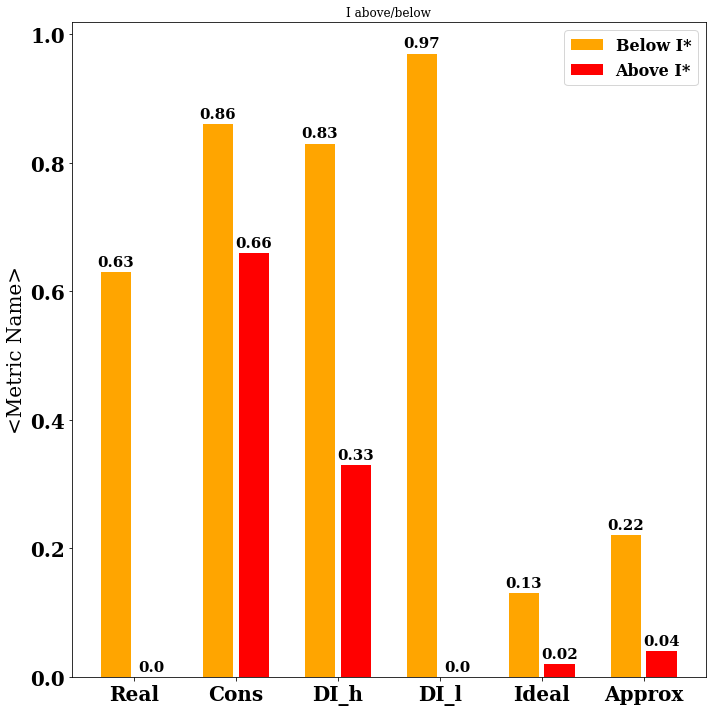

In [18]:
belowAbove = {}
# I_real_1 = [i*underreporting_factor for i in I_real]
belowAbove['Real'] = getIBelowAboveIstar(I_real_c, Istar)
belowAbove['Cons'] = getIBelowAboveIstar(I_cons, Istar)
belowAbove['DI_h'] = getIBelowAboveIstar(I_dI_h, Istar)
belowAbove['DI_l'] = getIBelowAboveIstar(I_dI_l, Istar)
belowAbove['Ideal'] = getIBelowAboveIstar(I_ideal, Istar)
belowAbove['Approx'] = getIBelowAboveIstar(I_approx, Istar)
print(belowAbove)
names = ['Real', 'Cons', 'DI_h', 'DI_l', 'Ideal', 'Approx']
belows = [round(belowAbove[n][0], 2) for n in names]
aboves = [round(belowAbove[n][1], 2) for n in names]



labels = ['Real', 'Cons', 'DI_h', 'DI_l', 'Ideal', 'Approx']


x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots(figsize=(10,10))
rects1 = ax.bar(x - width/2, belows, width*0.85, label='Below I*', color = 'orange')
rects2 = ax.bar(x + width/2, aboves, width*0.85, label='Above I*', color = 'red')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('<Metric Name>')
ax.set_title('I above/below')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()


def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom', fontsize=15)


autolabel(rects1)
autolabel(rects2)

fig.tight_layout()
plt.savefig('./graphs/{}_IcontrolMetrics.png'.format(meta['country']))
# plt.show()


{'Real': (0.9882874468774775, 0.0), 'Cons': (0.8556543082472167, 0.6623153751655104), 'DI_h': (0.8317368766205661, 0.3327482200017687), 'DI_l': (0.9707161850201405, 0.0), 'Ideal': (0.13107220209043255, 0.018571186245434388), 'Approx': (0.22129671675170595, 0.04245874726990164)}


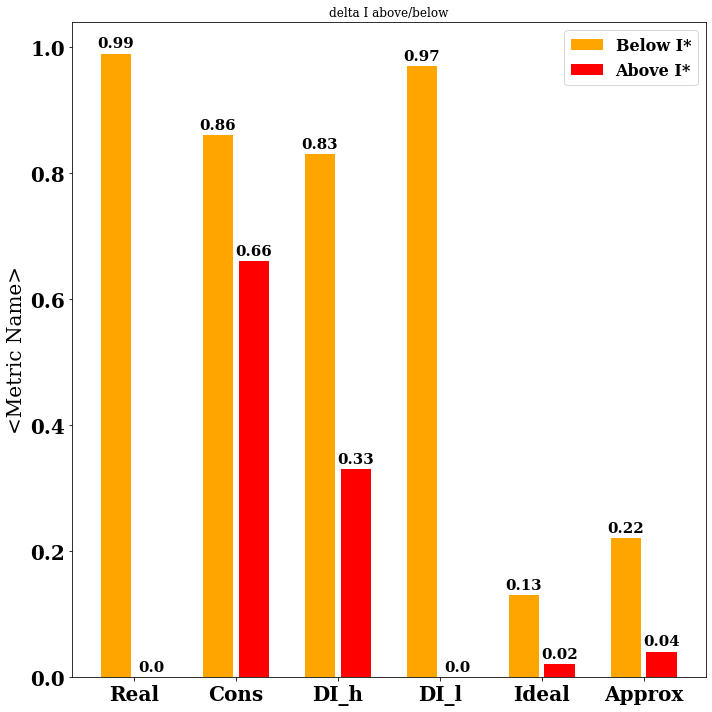

In [19]:
belowAbove = {}
belowAbove['Real'] = getIBelowAboveIstar(deltaI_real, Istar*gamma)
belowAbove['Cons'] = getIBelowAboveIstar(I_cons*gamma, Istar*gamma)
belowAbove['DI_h'] = getIBelowAboveIstar(I_dI_h*gamma, Istar*gamma)
belowAbove['DI_l'] = getIBelowAboveIstar(I_dI_l*gamma, Istar*gamma)
belowAbove['Ideal'] = getIBelowAboveIstar(I_ideal*gamma, Istar*gamma)
belowAbove['Approx'] = getIBelowAboveIstar(I_approx*gamma, Istar*gamma)
print(belowAbove)
names = ['Real', 'Cons', 'DI_h', 'DI_l', 'Ideal', 'Approx']
belows = [round(belowAbove[n][0], 2) for n in names]
aboves = [round(belowAbove[n][1], 2) for n in names]


labels = ['Real', 'Cons', 'DI_h', 'DI_l', 'Ideal', 'Approx']


x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots(figsize=(10,10))
rects1 = ax.bar(x - width/2, belows, width*0.85, label='Below I*', color = 'orange')
rects2 = ax.bar(x + width/2, aboves, width*0.85, label='Above I*', color = 'red')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('<Metric Name>')
ax.set_title('delta I above/below')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()


def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom', fontsize=15)


autolabel(rects1)
autolabel(rects2)

fig.tight_layout()

# plt.show()
plt.savefig('./graphs/{}_deltaIcontrolMetrics.png'.format(meta['country']))

In [20]:
# def getIBelowAboveIstar(I, Istar, buffer=0.1):
#     below = 0
#     above = 0
#     for i in I:
#         if(i<=Istar*(1-buffer)):
#             below += 1
#         elif(i>=Istar*(1+buffer)):
#             above += 1
#     return below, above

# belowAbove = {}
# belowAbove['Real'] = getIBelowAboveIstar(I_real, Istar)
# belowAbove['Cons'] = getIBelowAboveIstar(I_cons, Istar)
# belowAbove['DI_h'] = getIBelowAboveIstar(I_dI_h, Istar)
# belowAbove['DI_l'] = getIBelowAboveIstar(I_dI_l, Istar)
# belowAbove['Ideal'] = getIBelowAboveIstar(I_ideal, Istar)
# belowAbove['Approx'] = getIBelowAboveIstar(I_approx, Istar)

# names = ['Real', 'Cons', 'DI_h', 'DI_l', 'Ideal', 'Approx']
# belows = [belowAbove[n][0] for n in names]
# aboves = [belowAbove[n][1] for n in names]
# plt.figure(figsize=(10,6))
# plt.grid()
# plt.bar(range(len(names)), belows, bottom = aboves, width =0.8, color='orange', label = "Below Istar")
# plt.bar(range(len(names)), aboves, width =0.8, color = 'red', label = "Above Istar")
# plt.legend()
# plt.xticks(range(len(names)), names)

In [21]:
def betaTrend(betaList):
    below = []
    above = []
    minBeta = 0
    x = [minBeta + float(i)/20 for i in range(11)]
    for b in x:
        tempbelow = 0
        tempabove = 0
        for beta in betaList:
            if(beta<=b):
                tempbelow+=1
            else:
                tempabove+=1
        below.append(tempbelow)
        above.append(tempabove)
    return below, above, x
                

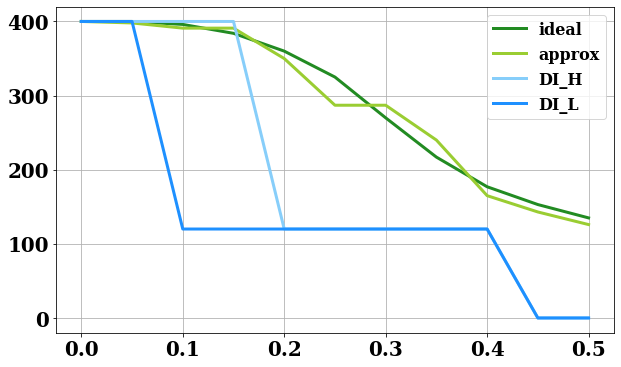

In [22]:
plt.figure(figsize=(10,6))
b, a, x = betaTrend(beta_ideal)
plt.plot(x, a, label='ideal', color='forestgreen')
b, a, x = betaTrend(beta_approx)
plt.plot(x, a, label = 'approx', color='yellowgreen')
b, a, x = betaTrend(beta_dI_h)
plt.plot(x, a, label = 'DI_H', color='lightskyblue')
b, a, x = betaTrend(beta_dI_l)
plt.plot(x, a, label = 'DI_L', color='dodgerblue')
plt.legend()
plt.grid()
plt.savefig('./graphs/{}_visualisestrictness.png'.format(meta['country']))

<Figure size 432x288 with 0 Axes>

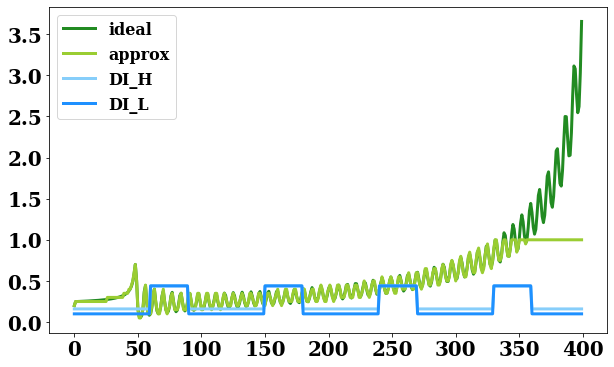

In [23]:
plt.clf()
plt.figure(figsize=(10,6))
l = len(beta_ideal)
plt.plot(range(l), beta_ideal, label='ideal', color='forestgreen')
plt.plot(range(l), beta_approx, label='approx', color='yellowgreen')
plt.plot(range(l), beta_dI_h, label='DI_H', color='lightskyblue')
plt.plot(range(l), beta_dI_l, label='DI_L', color='dodgerblue')
plt.legend()
plt.savefig('./graphs/{}_beta.png'.format(meta['country']))

In [24]:
# Idict = {}
# betadict = {}
# Idict['CoSIR_Ideal'] = I_ideal
# betadict['CoSIR_Ideal'] = beta_ideal

# Idict['CoSIR_approx'] = I_approx
# betadict['CoSIR_approx'] = beta_approx

# Idict['Dynamic_Intervention_0.8'] = I_dI_h
# betadict['Dynamic_Intervention_0.8'] = beta_dI_h

# Idict['Dynamic_Intervention_0.5'] = I_dI_l
# betadict['Dynamic_Intervention_0.5'] = beta_dI_l


# Idict['Constant beta'] = I_cons
# betadict['Constant beta'] = beta_cons

# Idict['Real'] = I_real

In [25]:
# Idf = pd.DataFrame(dict([ (k, pd.Series(v)) for k,v in Idict.items() ]))
# betadf = pd.DataFrame(dict([ (k, pd.Series(v)) for k,v in betadict.items() ]))

In [19]:
# Idf.to_csv('./Mexico_I.csv')
# betadf.to_csv('./Mexico_beta.csv')